# Personalized Recommendation system 

- We will make personalized recomeendation system based on set of categories 

- there are three categories created in this notebook : 

**the first one is** : "Children" and it's criteria is : age less than 12 years

**the second one is** : "Teens"  and it's  criteria is:  age between 12 and 18 years

**the third one is** : "Adults" and it's criteria is :  age larger than 18 years

# About dataset

We use MovieLens 1M movie ratings. Stable benchmark dataset. 1 million ratings from 6000 users on 4000 movies. Released 2/2003.

these version of dataset contains "age - gender" Attributes for making recommendation for different clients based on there age 

# Preparing Python Environment

In [1]:
#install needed libraries
!pip install git+http://github.com/brendanhasz/dsutils.git
!pip install wordcloud
!pip install scikit-surprise
!pip install chardet

  Cloning http://github.com/brendanhasz/dsutils.git to c:\users\mostafa\appdata\local\temp\pip-req-build-i13_pk63
  Resolved http://github.com/brendanhasz/dsutils.git to commit e780e904f7bf0ec5e14aa7ddb337f01f29779143
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  Running command git clone --filter=blob:none --quiet http://github.com/brendanhasz/dsutils.git 'C:\Users\mostafa\AppData\Local\Temp\pip-req-build-i13_pk63'
  ERROR: Error [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software while executing command python setup.py egg_info
ERROR: Could not install packages due to an OSError: [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software



# Import Required Libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
# from dsutils.printing import print_table, describe_df
sns.set_style('dark')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import StandardScaler
import surprise
from surprise import SVD
import tensorflow as tf
from surprise import accuracy
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense
from tensorflow.keras.models import Model

from wordcloud import WordCloud
from surprise import Dataset, Reader, KNNBasic
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Exploration

### Ratings dataset

In [3]:
ratings_df = pd.read_csv('ratings.dat',names=["UserID","MovieID","Rating","Timestamp"],sep="::")
ratings_df.head()

C:\Users\mostafa\AppData\Local\Temp\ipykernel_18836\3485802121.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_df = pd.read_csv('ratings.dat',names=["UserID","MovieID","Rating","Timestamp"],sep="::")


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


We can see from the above output that the rating dataset contains the userId, movieId, ratings, and timestamp columns. Each row in the dataset corresponds to one rating. The userId column contains the ID of the user who left the rating. The movieId column contains the Id of the movie, the rating column contains the rating left by the user. Ratings can have values between 1 and 5. And finally, the timestamp refers to the time at which the user left the rating.

**The rating dataset contains 1,000,209 ratings for  3,900 movies by 6,040 users**

**and there are no missing values anywhere in ratings dataset**

**Convert rating timestap to date type**

In [4]:
ratings_df['Timestamp'] = pd.to_datetime(ratings_df['Timestamp'],unit='s')

**Checking the duplications in ratings dataset**

In [5]:
print("The number of duplicate rows in ratings dataset: %d"
      % ratings_df.duplicated().sum())

The number of duplicate rows in ratings dataset: 0


### Data visualization for ratings dataset

**we'll plot a histogram for average ratings**

<Axes: title={'center': 'Average ratings'}>

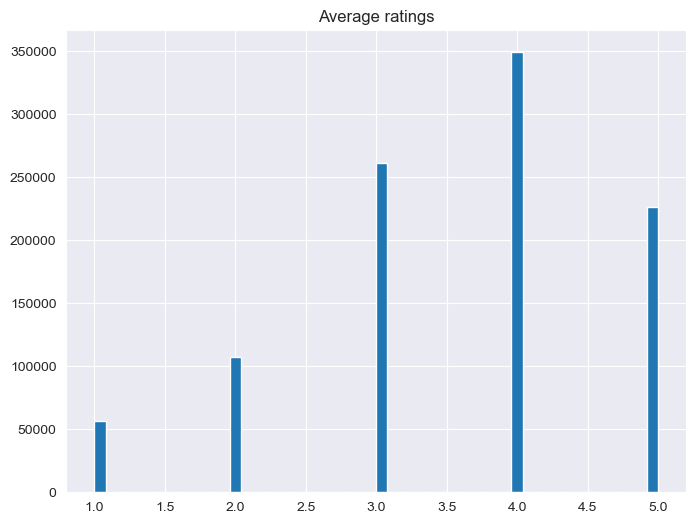

In [6]:
plt.figure(figsize=(8,6))
plt.title('Average ratings')
plt.rcParams['patch.force_edgecolor'] = True
ratings_df['Rating'].hist(bins=50)

We can see that the integer values have taller bars than the floating values since most of the users assign rating as integer value i.e. 1, 2, 3, 4 or 5. Furthermore, it is evident that the data has a weak normal distribution with the mean of around 3.5

In [7]:
# creating a dataframe with grouped ratings by movieid
ratings_mean_count = pd.DataFrame(ratings_df.groupby('MovieID')['Rating'].mean())

In [8]:
# adding rating count for every movie
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings_df.groupby('MovieID')['Rating'].count())

In [9]:
ratings_mean_count.head()

,Rating,rating_counts
MovieID,,
1,4.146846,2077
2,3.201141,701
3,3.016736,478
4,2.729412,170
5,3.006757,296


In [10]:
ratings_mean_count["Rating"].describe()

count    3706.000000
mean        3.238892
std         0.672925
min         1.000000
25%         2.822705
50%         3.331546
75%         3.740741
max         5.000000
Name: Rating, dtype: float64

<Axes: title={'center': 'rating counts'}>

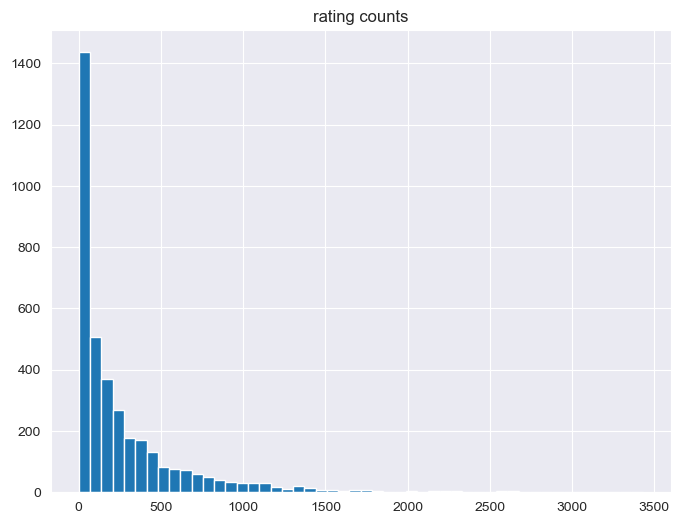

In [11]:
plt.figure(figsize=(8,6))
plt.title('rating counts')
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

From the output, you can see that most of the movies have received less than 50 ratings. While the number of movies having more than 100 ratings is very low.

**Ploting average ratings against the number of ratings**

movies with a higher number of ratings usually have a high average rating as well since a good movie is normally well-known and a well-known movie is watched by a large number of people.

**Let's see if this is also the case with the movies in our dataset**

<Figure size 1000x800 with 0 Axes>

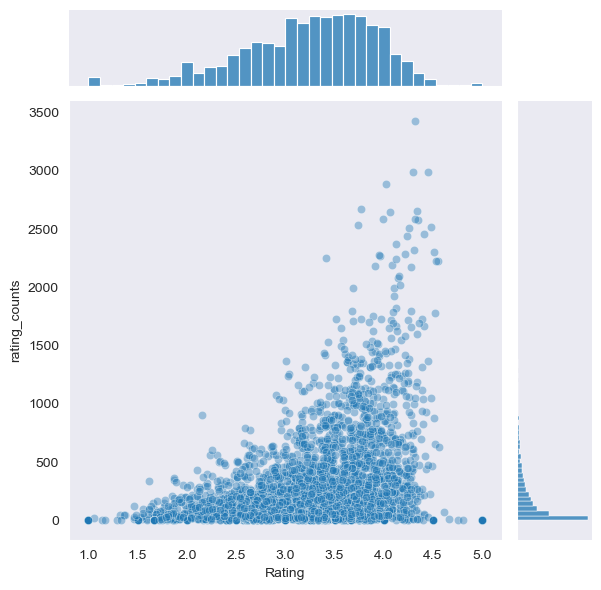

In [12]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
plt.suptitle('Average ratings VS Number of ratings')
p = sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

The graph shows that, in general, movies with higher average ratings actually have more number of ratings, compared with movies that have lower average ratings.

### Users dataset

In [13]:
users = pd.read_csv("users.dat", names=["UserID","Gender","Age","Occupation","Zip-code"], sep= "::")

C:\Users\mostafa\AppData\Local\Temp\ipykernel_18836\503020272.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv("users.dat", names=["UserID","Gender","Age","Occupation","Zip-code"], sep= "::")


In [14]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [16]:
users.duplicated().sum()

0

In [17]:
users["UserID"].nunique()

6040

In [18]:
users["Gender"].value_counts()

M    4331
F    1709
Name: Gender, dtype: int64

<Axes: xlabel='Gender', ylabel='count'>

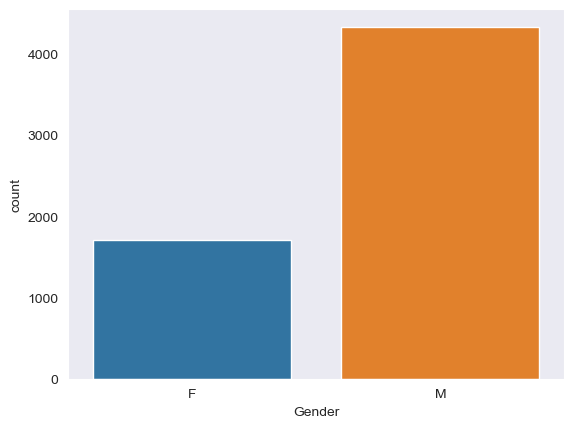

In [19]:
sns.countplot(x= users["Gender"])

In [20]:
users["Age"].describe()

count    6040.000000
mean       30.639238
std        12.895962
min         1.000000
25%        25.000000
50%        25.000000
75%        35.000000
max        56.000000
Name: Age, dtype: float64

<Axes: xlabel='Age', ylabel='Count'>

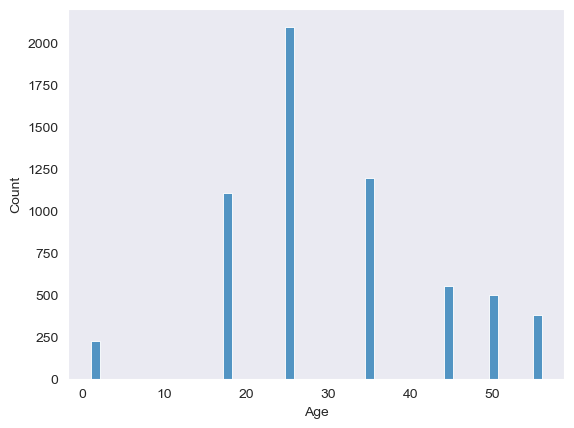

In [21]:
sns.histplot(x= users["Age"])

In [22]:
users["Occupation"].value_counts().sort_values(ascending=False)

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: Occupation, dtype: int64

<Axes: xlabel='Occupation', ylabel='count'>

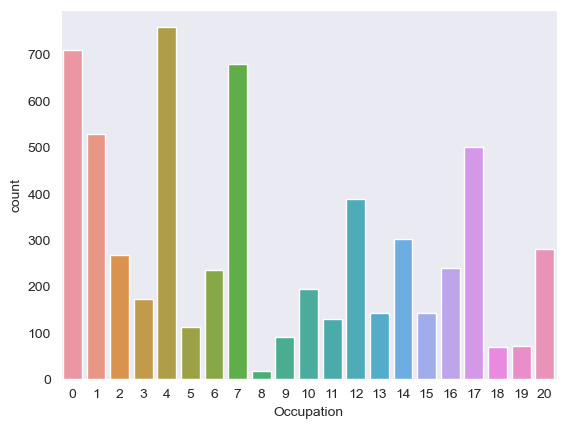

In [23]:
sns.countplot(x= users["Occupation"])

<Axes: xlabel='Occupation', ylabel='count'>

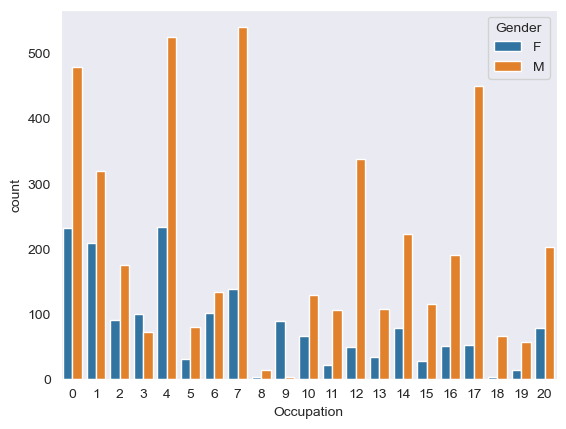

In [24]:
sns.countplot(data= users, x= users["Occupation"], hue= users["Gender"])

### Movies dataset

In [25]:
movies_data=pd.read_csv('movies.dat', names= ["MovieID","Title","Genres"], sep="::")

C:\Users\mostafa\AppData\Local\Temp\ipykernel_18836\3919051084.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies_data=pd.read_csv('movies.dat', names= ["MovieID","Title","Genres"], sep="::")


In [26]:
movies_data.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [28]:
movies_data.describe(include="all")

,MovieID,Title,Genres
count,3883.000000,3883,3883
unique,NaN,3883,301
top,NaN,Toy Story (1995),Drama
freq,NaN,1,843
mean,1986.049446,NaN,NaN
std,1146.778349,NaN,NaN
min,1.000000,NaN,NaN
25%,982.500000,NaN,NaN
50%,2010.000000,NaN,NaN
75%,2980.500000,NaN,NaN


In [29]:
movies_data.dtypes

MovieID     int64
Title      object
Genres     object
dtype: object

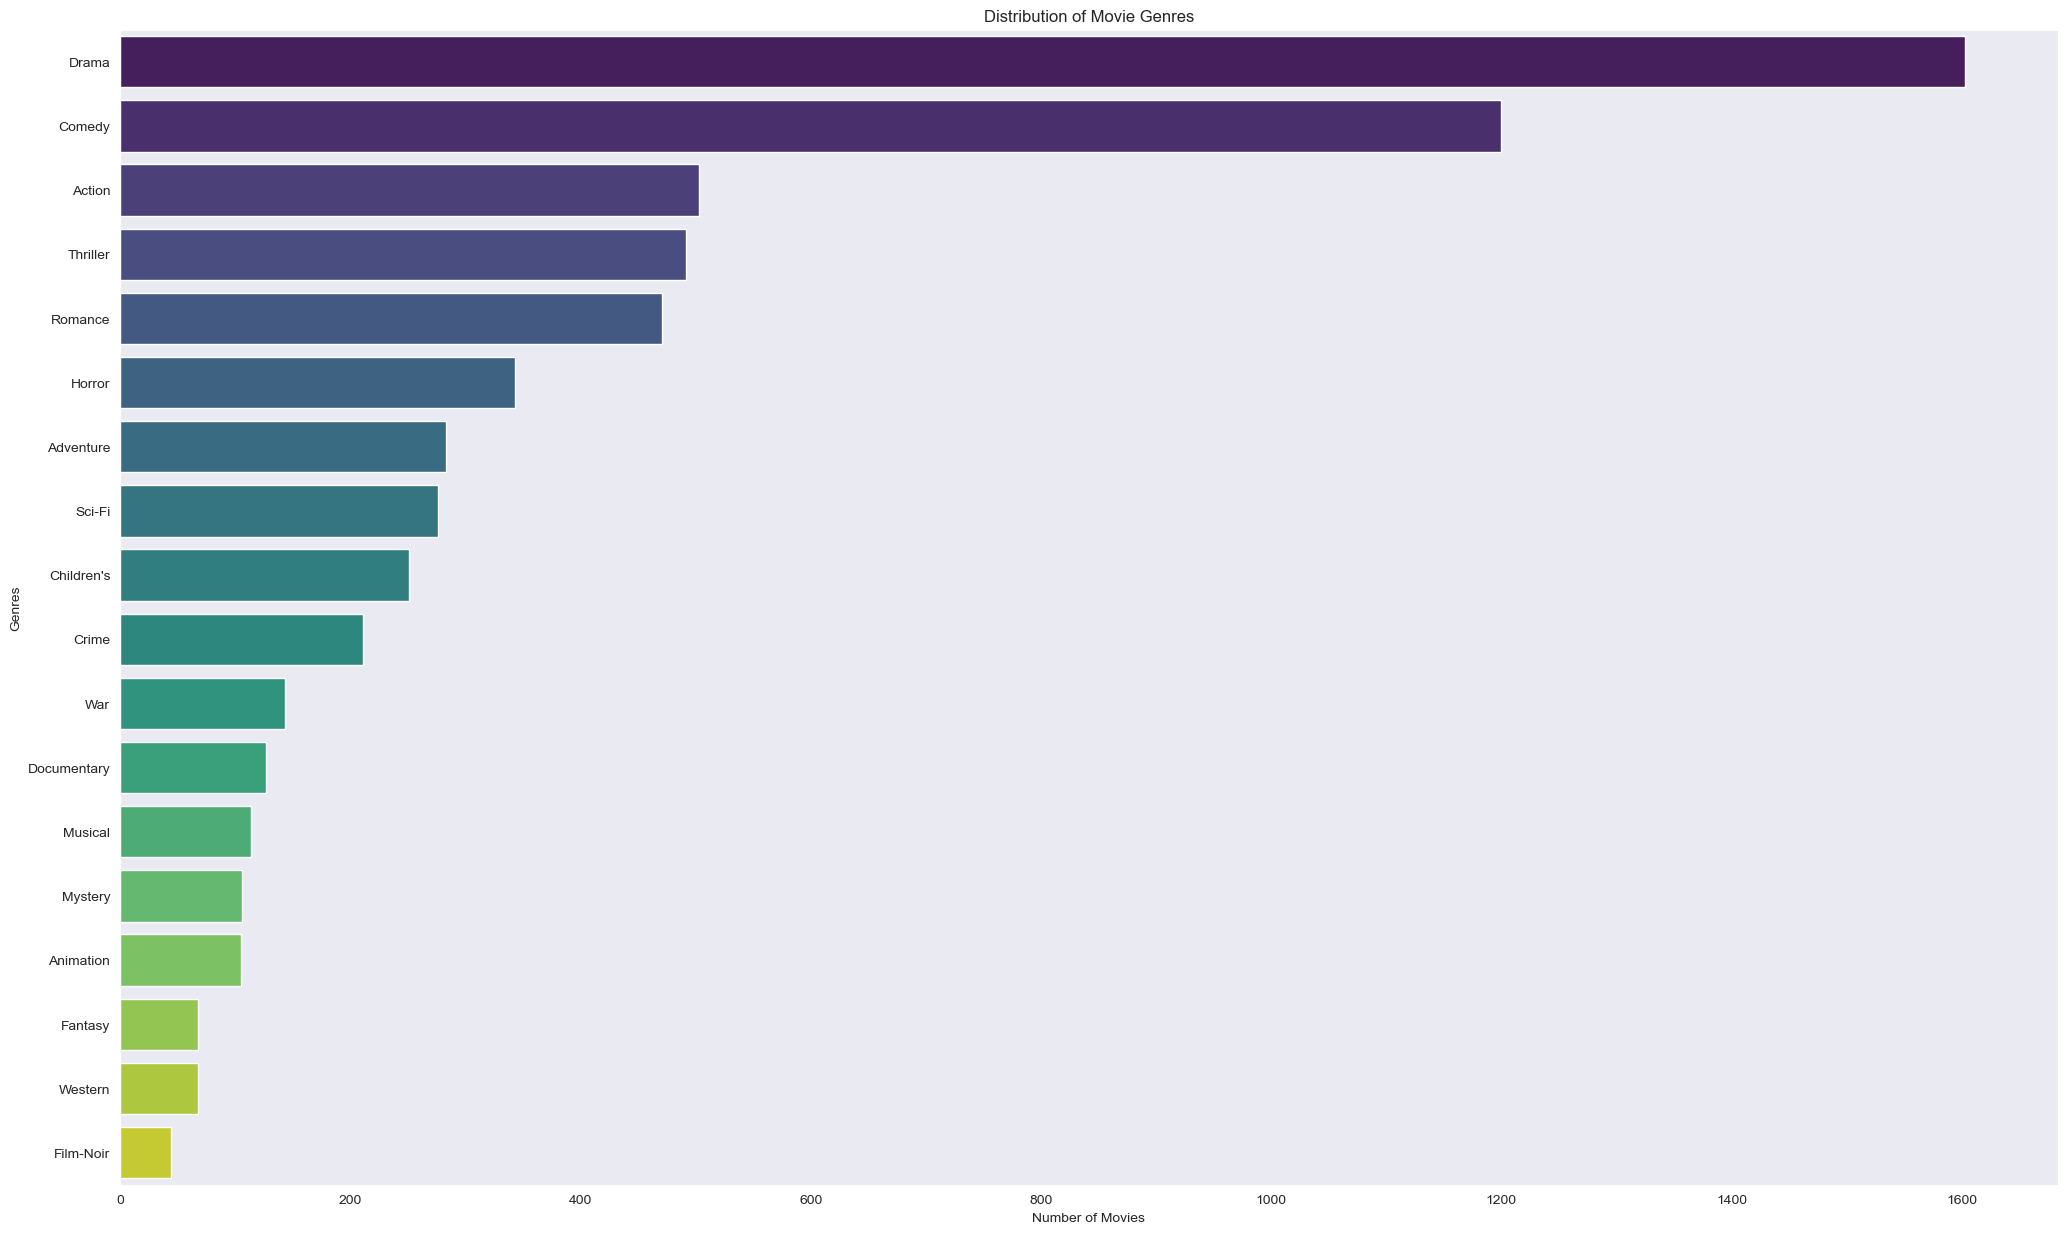

In [30]:
# Visualize the distribution of movie genres
genres_counts = movies_data['Genres'].str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(25, 15))
sns.barplot(x=genres_counts.values, y=genres_counts.index, palette='viridis')
plt.title('Distribution of Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genres')
plt.show()

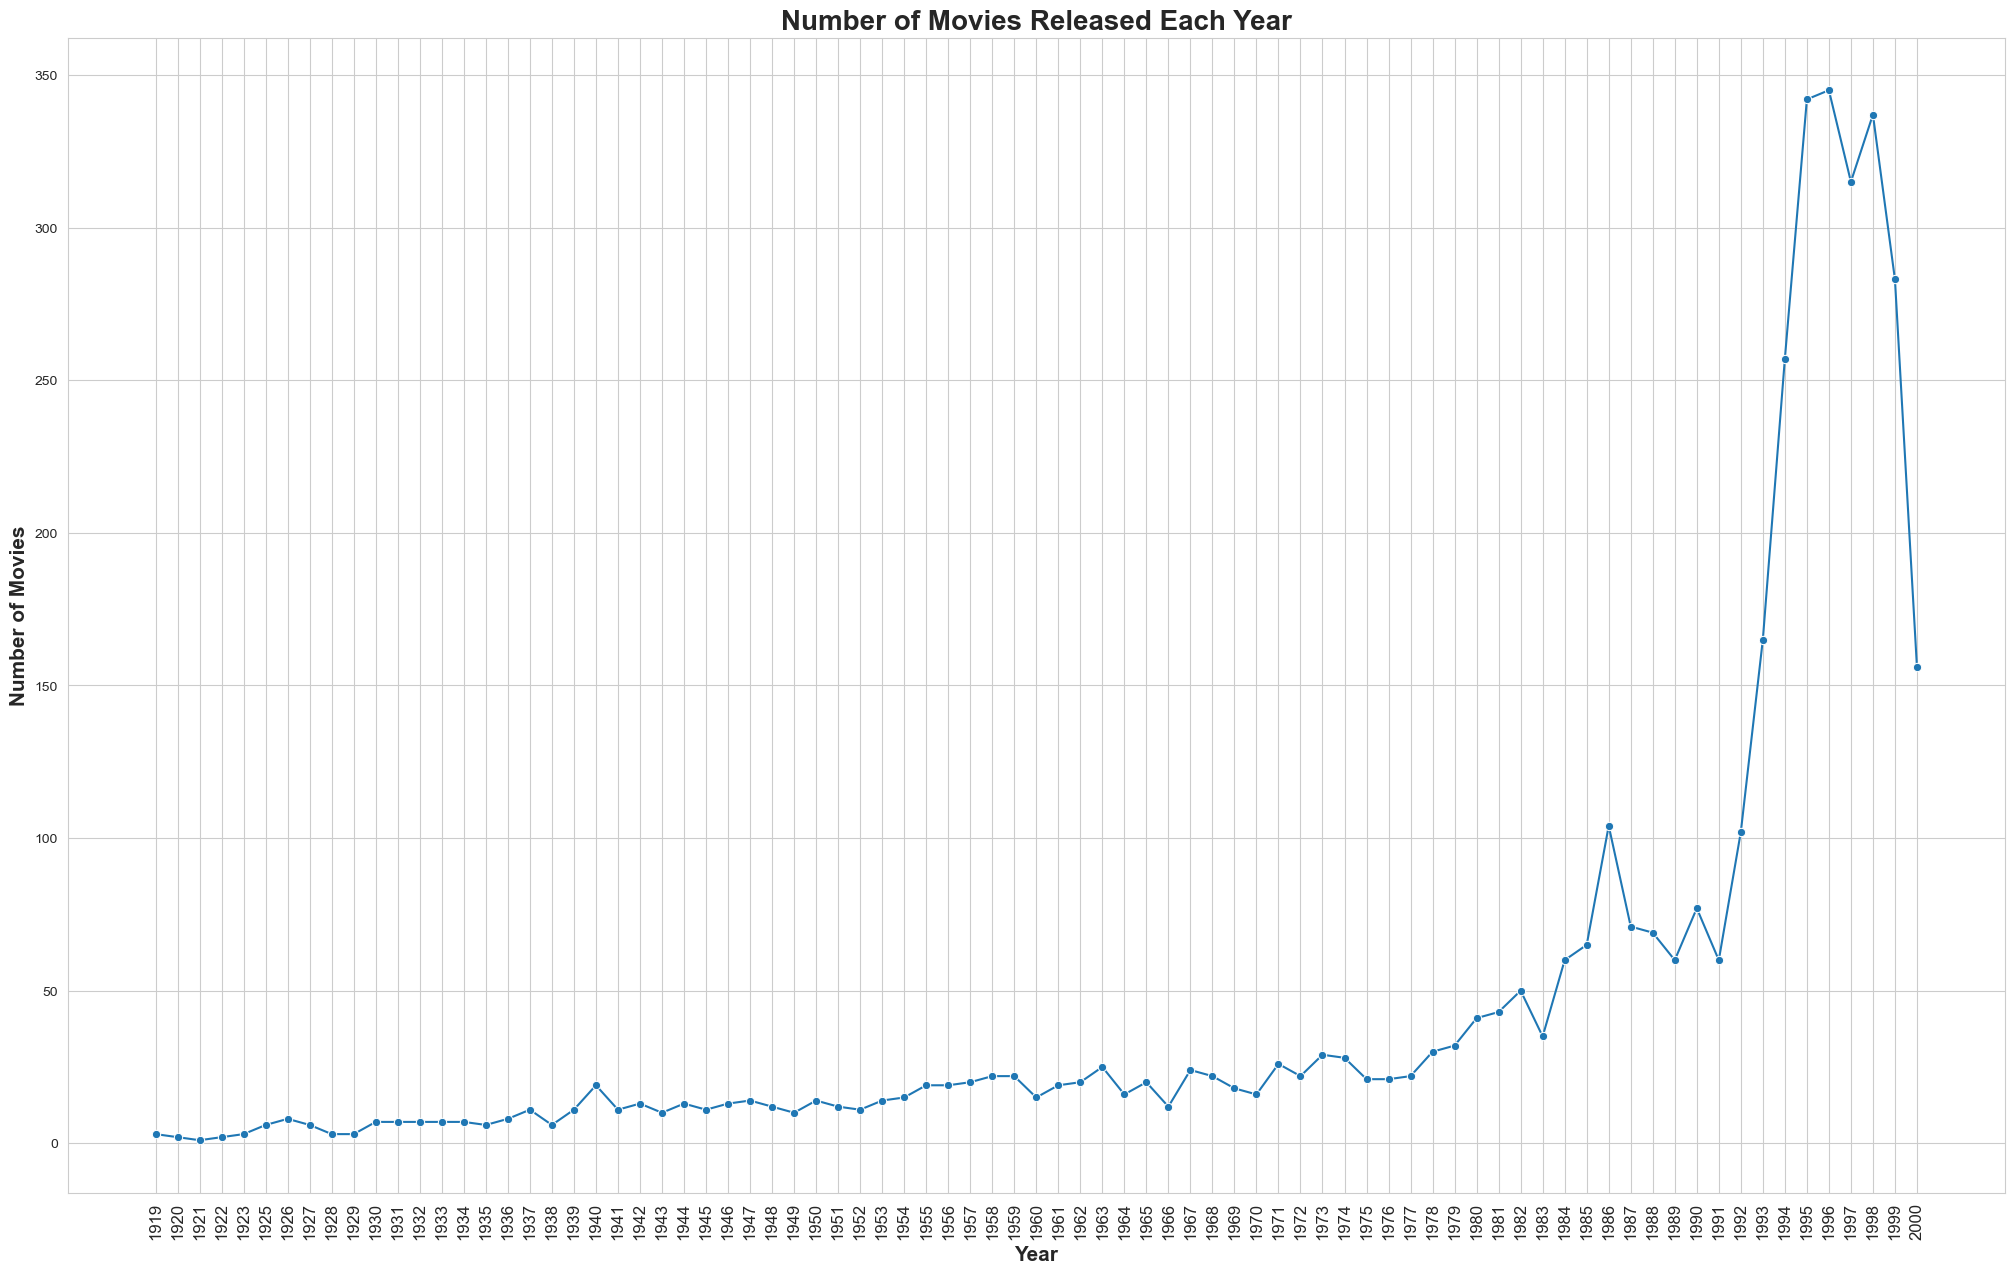

In [31]:
# Visualize the number of movies released each year
# Set the style
sns.set_style("whitegrid")
movies_data['year'] = movies_data['Title'].str.extract(r'\((\d{4})\)')
year_counts = movies_data['year'].value_counts().sort_index()
plt.figure(figsize=(25, 15))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.title('Number of Movies Released Each Year',fontweight='bold',fontsize=20)
plt.xlabel('Year',fontweight='bold',fontsize=15)
plt.ylabel('Number of Movies',fontweight='bold',fontsize=15)
plt.xticks(rotation=90,fontsize=12)
plt.show()

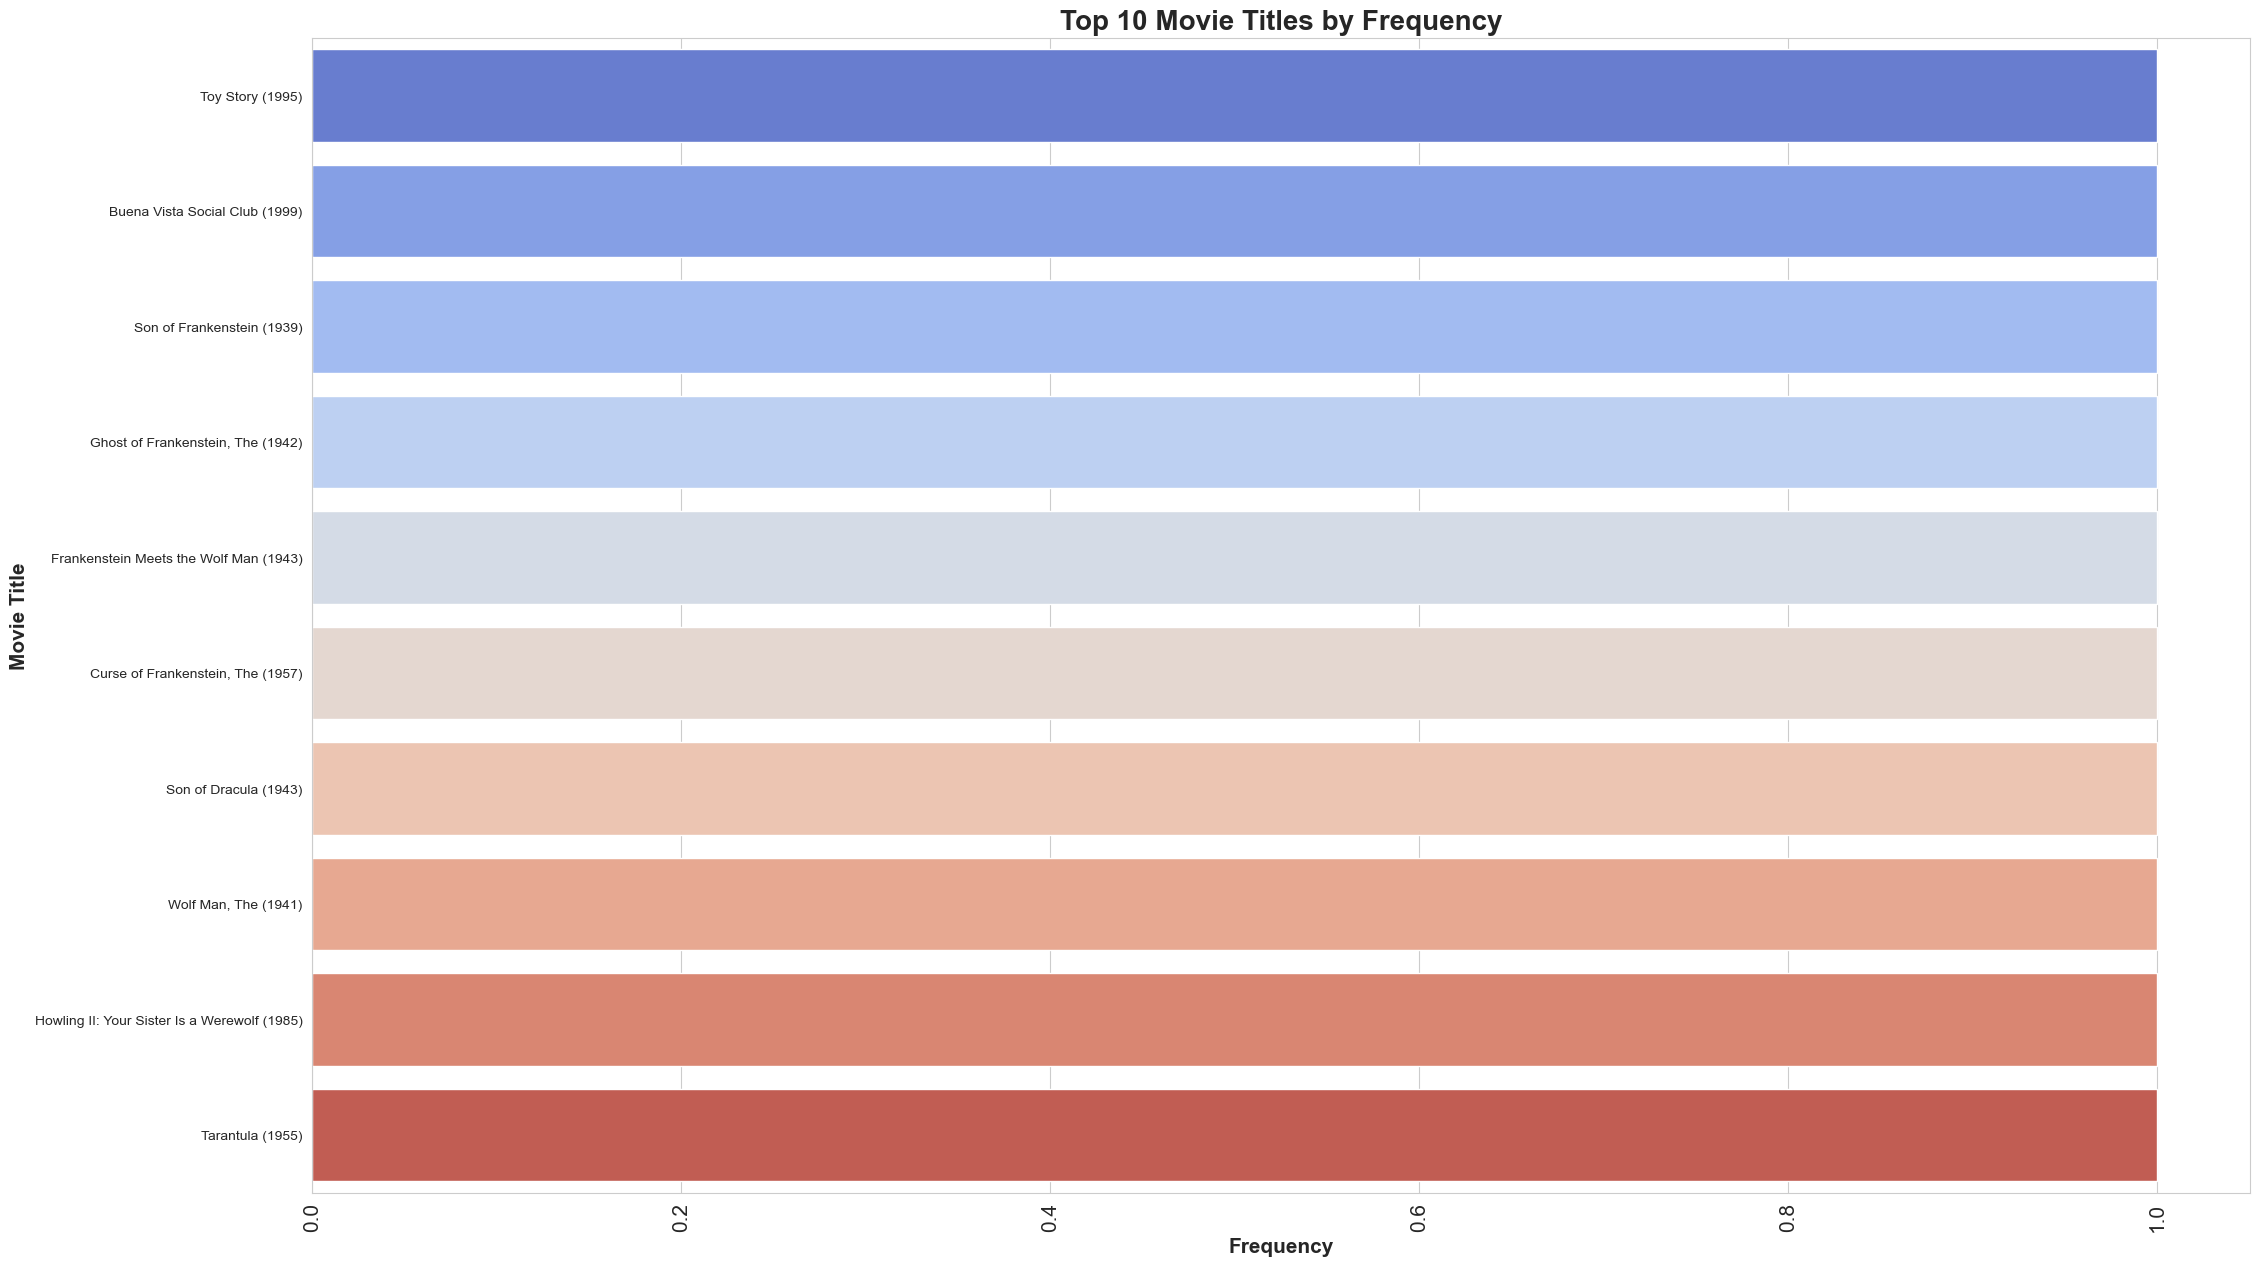

In [32]:
# Visualize the top movie titles by frequency
top_titles = movies_data['Title'].value_counts()[:10]
plt.figure(figsize=(25, 15))
sns.barplot(x=top_titles.values, y=top_titles.index, palette='coolwarm')
plt.title('Top 10 Movie Titles by Frequency',fontweight='bold',fontsize=20)
plt.xlabel('Frequency',fontweight='bold',fontsize=15)
plt.ylabel('Movie Title',fontweight='bold',fontsize=15)
plt.xticks(rotation=90,fontsize=15)
plt.show()

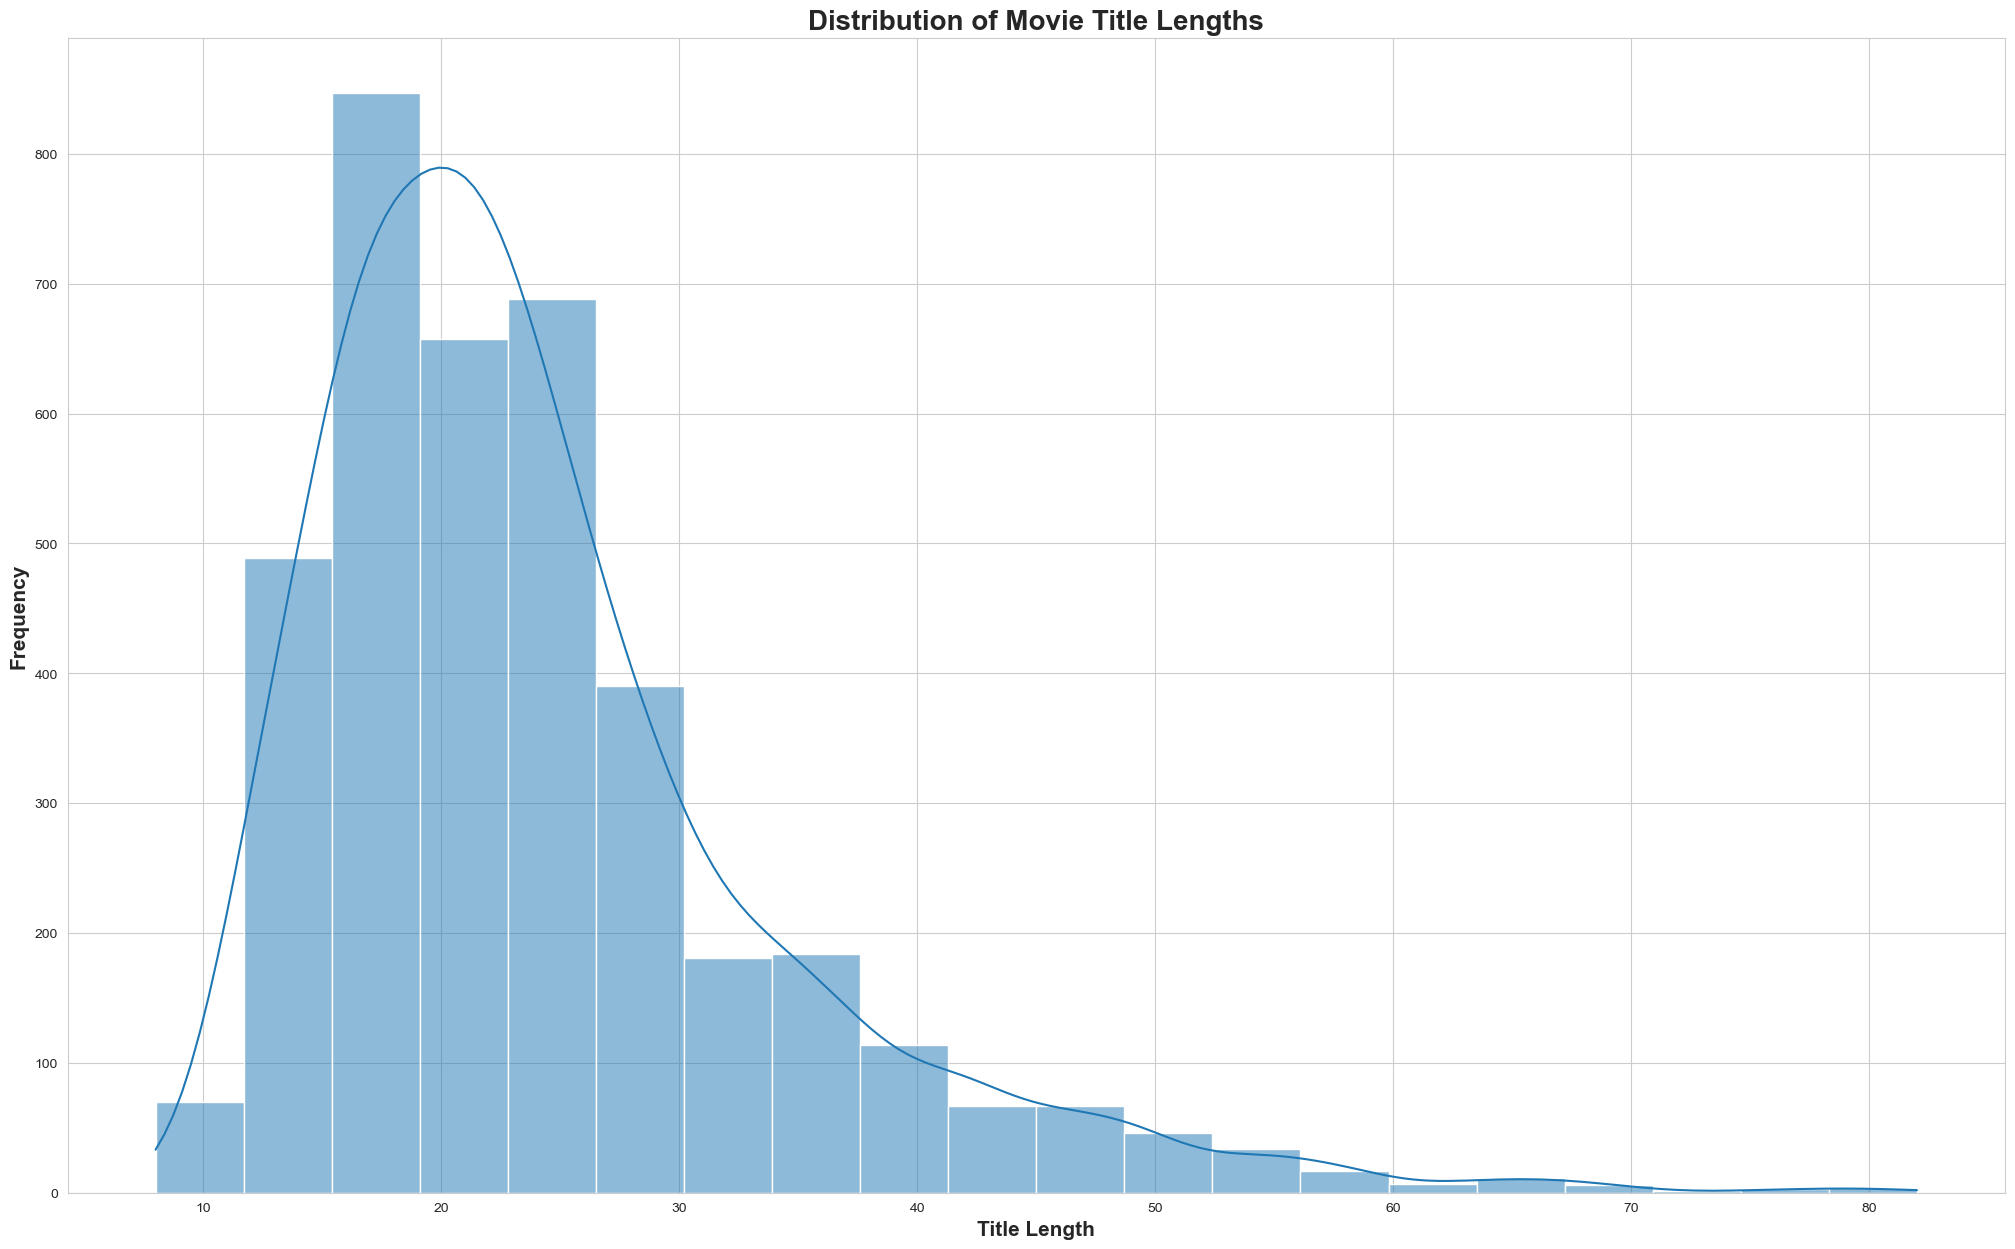

In [33]:
# Visualize the distribution of movie title lengths
movies_data['title_length'] = movies_data['Title'].apply(len)
plt.figure(figsize=(25, 15))
sns.histplot(data=movies_data, x='title_length', bins=20, kde=True)
plt.title('Distribution of Movie Title Lengths',fontweight='bold',fontsize=20)
plt.xlabel('Title Length',fontweight='bold',fontsize=15)
plt.ylabel('Frequency',fontweight='bold',fontsize=15)
plt.show()

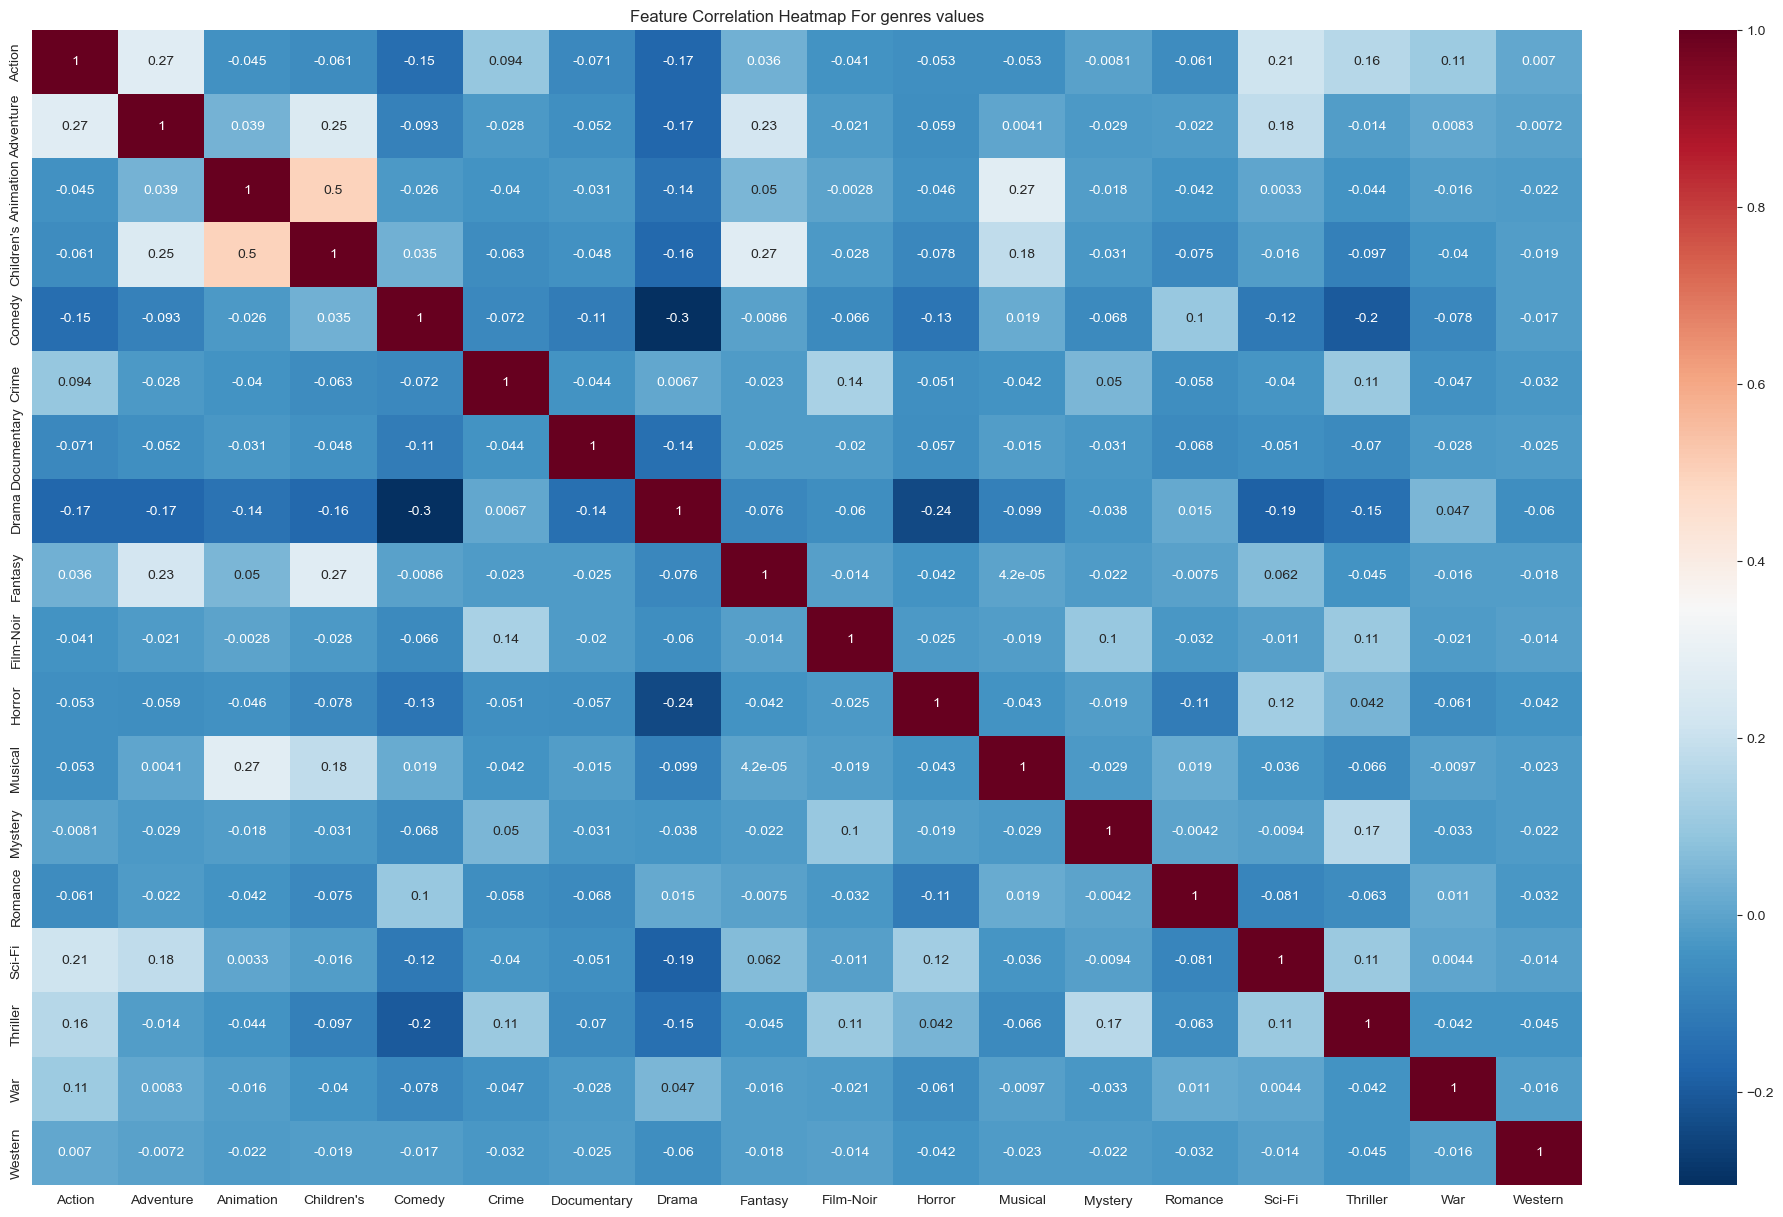

In [34]:
# Encode genres into binary columns
genres_encoded = movies_data['Genres'].str.get_dummies('|')

# Concatenate encoded genres with the original DataFrame
df_encoded = pd.concat([ genres_encoded], axis=1)

# Calculate correlations
correlation_matrix = df_encoded.corr()

# Create a heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, cmap='RdBu_r', annot=True)
plt.title('Feature Correlation Heatmap For genres values')
plt.show()

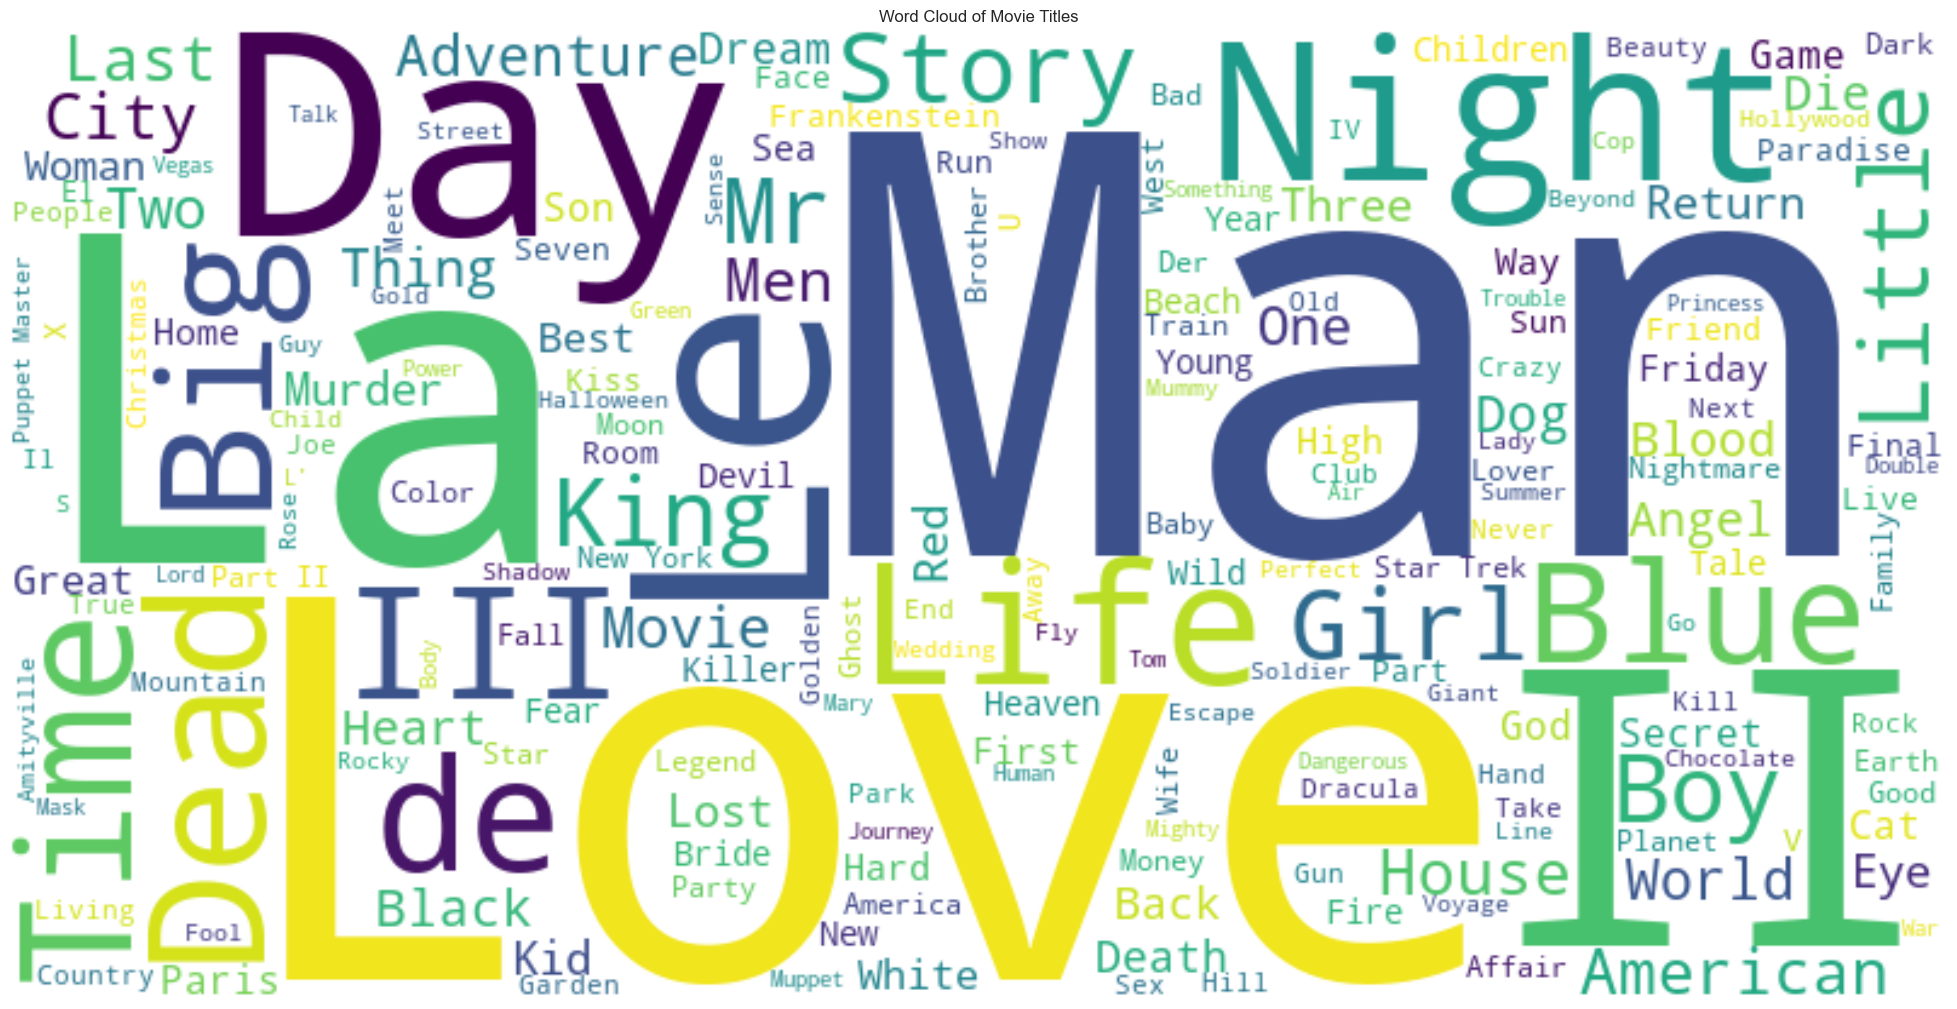

In [35]:
# Combine all movie titles into a single string
titles_text = ' '.join(movies_data['Title'])
plt.figure(figsize=(25, 15))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(titles_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Movie Titles')
plt.axis('off')
plt.show()

In [36]:
movies_data.drop(['year'], axis=1, inplace=True)
movies_data.drop(['title_length'], axis=1, inplace=True)

# Preprocessing

In [37]:
# Check for Duplicate Rows based on 'movieId' and 'title'
duplicate_rows = movies_data[movies_data.duplicated(subset=['MovieID', 'Title'])]
if not duplicate_rows.empty:
    print("Duplicate Rows:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [38]:
# Check for Null Values
null_values = movies_data.isnull().sum()
print("\nNull Values:")
print(null_values)


Null Values:
MovieID    0
Title      0
Genres     0
dtype: int64


In [39]:
# check outlier
# Count the number of genres for each movie
movies_data['num_genres'] = movies_data['Genres'].apply(lambda x: len(x.split('|')))

# Calculate the median and interquartile range (IQR)
median = movies_data['num_genres'].median()
Q1 = movies_data['num_genres'].quantile(0.25)
Q3 = movies_data['num_genres'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers based on the IQR criterion
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = movies_data[(movies_data['num_genres'] < lower_bound) | (movies_data['num_genres'] > upper_bound)]

print("Outliers:")
print(outliers)

Outliers:
      MovieID                          Title  \
47         48              Pocahontas (1995)   
69         70     From Dusk Till Dawn (1996)   
105       107  Muppet Treasure Island (1996)   
151       153          Batman Forever (1995)   
158       160                   Congo (1995)   
...       ...                            ...   
3265     3334               Key Largo (1948)   
3515     3584              Breathless (1983)   
3630     3699                 Starman (1984)   
3636     3705          Bird on a Wire (1990)   
3701     3770              Dreamscape (1984)   

                                    Genres  num_genres  
47    Animation|Children's|Musical|Romance           4  
69     Action|Comedy|Crime|Horror|Thriller           5  
105    Adventure|Children's|Comedy|Musical           4  
151          Action|Adventure|Comedy|Crime           4  
158        Action|Adventure|Mystery|Sci-Fi           4  
...                                    ...         ...  
3265        Cr

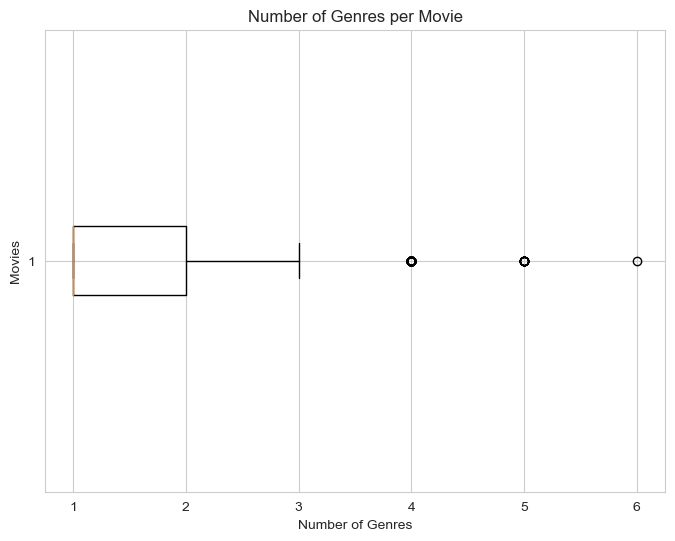

In [40]:
# Count the number of genres for each movie
movies_data['num_genres'] = movies_data['Genres'].apply(lambda x: len(x.split('|')))
# Create a box plot
plt.figure(figsize=(8, 6))
plt.boxplot(movies_data['num_genres'], vert=False)
plt.title('Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Movies')
plt.show()

In [41]:
# Extract release year from title
movies_data['year'] = movies_data['Title'].str.extract(r'\((\d{4})\)')

In [42]:
# Remove the year from the title
movies_data['title'] = movies_data['Title'].str.replace(r'\(\d{4}\)', '').str.strip()

C:\Users\mostafa\AppData\Local\Temp\ipykernel_18836\2374453188.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  movies_data['title'] = movies_data['Title'].str.replace(r'\(\d{4}\)', '').str.strip()


In [43]:
# Split genres and create binary columns for each genre using one-hot encoding
genres_split = movies_data['Genres'].str.get_dummies('|')
movies_data = pd.concat([movies_data, genres_split], axis=1)

In [44]:
# Drop unnecessary columns
movies_data.drop(['Genres'], axis=1, inplace=True)
movies_data.drop(['num_genres'], axis=1, inplace=True)

### Merging the two tables (ratings, movies)

In [45]:
movies_data.head()

,MovieID,Title,year,title,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,Toy Story,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,Jumanji,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,Grumpier Old Men,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995,Waiting to Exhale,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,Father of the Bride Part II,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [47]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [48]:
# Merge tables based on common columns (e.g., MovieID and UserID)
merged_data = pd.merge(ratings_df, users, on='UserID')  
merged_data = pd.merge(merged_data, movies_data, on='MovieID')

# Model

In [49]:
# Define groups and criteria
group_criteria = {
    'Children': (merged_data['Age'] <= 12),
    'Teens': (merged_data['Age'] > 12) & (merged_data['Age'] <= 18),
    'Adults': (merged_data['Age'] > 18),
}

In [50]:
# Build a collaborative filtering model (KNN) using the merged dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_data[['UserID', 'MovieID', 'Rating']], reader)
trainset = data.build_full_trainset()
model = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [51]:
# Create a dictionary to map MovieID to Title
# this dictionary to return title of Movie instead of id of Movies
movie_id_to_title = dict(zip(movies_data['MovieID'], movies_data['Title']))

In [52]:
# Function to get recommendations for a specific user in a group
'''
Input data is : user id - group which user belongs - number of recommended movies(default parameter)
output : list of top ten recommended movies 

'''

def get_recommendations(group, user_id, top_n=10):
    # if user choose invalid group , show message "Invalid group"
    # if the user try to write categories out of "group_criteria"
    if group not in group_criteria:
        return "Invalid group"
    
    '''
    - Check if the user is in the specified group
    - if user choose wrong group show "Warning Message"
    EX : if the age of user is 10 and write the group which he belong is "Teens" ,
    this wrong group , the group of the age is "Children" , so that the system retreive 
    warning message to users
    
    '''
    user_in_group = merged_data[(merged_data['UserID'] == user_id) & group_criteria[group]].shape[0] > 0
    
    if not user_in_group:
        return "User not found in the specified group"

    # Get user's history
    # get the movies of users which give rate more than 4 
    user_history = merged_data[(merged_data['UserID'] == user_id) & (merged_data['Rating'] >= 4)]
    # store all movies id in list(movies rate greater than 4) 
    user_movie_ids = user_history['MovieID'].tolist()

    # Make recommendations for the user
    # retrieve movies that have height expected weight , these movies user not react with before 
    top_movie_ids = []
    for movie_id in range(1, 3953):  # Assuming you have a total of 3952 movies
        if movie_id not in user_movie_ids:
            prediction = model.predict(user_id, movie_id)
            top_movie_ids.append((movie_id, prediction.est))
    # sort the retrieve movies descending based on expected weight(rate) for each movie 
    top_movie_ids.sort(key=lambda x: x[1], reverse=True)
    top_movie_ids = [movie[0] for movie in top_movie_ids[:top_n]]

    # Map movie IDs to titles and remove year from recommended movies 
    # top_movie_titles = [movie_id_to_title[movie_id] for movie_id in top_movie_ids]
    top_movie_titles = [movie_id_to_title[movie_id].rsplit('(', 1)[0].strip() for movie_id in top_movie_ids]

    # return titles of these recommended movies 
    return top_movie_titles


In [53]:
# Input data (examble)
# user must Specify the group
group_input = 'Children' 
# user must Specify the user ID
user_input = 1  
# call the function 
recommendations = get_recommendations(group_input, user_input)

# return top ten movies for users 
if isinstance(recommendations, list):
    print(f"Top {len(recommendations)} Movie Recommendations for {group_input} Group and User {user_input}:")
    for movie_title in recommendations:
        print(movie_title)
else:
    print(recommendations)

Top 10 Movie Recommendations for Children Group and User 1:
Schlafes Bruder (Brother of Sleep)
Follow the Bitch
Ulysses (Ulisse)
Smashing Time
Song of Freedom
One Little Indian
Lured
Bittersweet Motel
Gate of Heavenly Peace, The
Sanjuro


let's make another examble if the user enter "wrong group" based on his age 

In [54]:
# Input data (examble)
# user must Specify the group
group_input = 'Adults' 
# user must Specify the user ID
user_input = 1  
# call the function 
recommendations = get_recommendations(group_input, user_input)

# return top ten movies for users 
if isinstance(recommendations, list):
    print(f"Top {len(recommendations)} Movie Recommendations for {group_input} Group and User {user_input}:")
    for movie_title in recommendations:
        print(movie_title)
else:
    print(recommendations)

User not found in the specified group


Invalid Message , beacuse user enter "Adults" group instead of "Children"

# Deploy Model 

In [55]:
!pip install scikit-surprise

In [56]:
# import pandas as pd

# # Load and merge the three tables
# movies_data = pd.read_csv('movies.dat', names=["MovieID", "Title", "Genres"], sep="::")
# ratings_data = pd.read_csv('ratings.dat', names=["UserID", "MovieID", "Rating", "Timestamp"], sep="::")
# users_data = pd.read_csv("users.dat", names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], sep="::")

# # Merge tables based on common columns (e.g., MovieID and UserID)
# merged_data = pd.merge(ratings_data, users_data, on='UserID')
# merged_data = pd.merge(merged_data, movies_data, on='MovieID')

# # Save the merged data to a CSV file
# merged_data.to_csv('merged_data.csv', index=False)

In [57]:
# %%writefile app1000.py
# import numpy as np
# import streamlit as st
# import pandas as pd 
# import matplotlib.pyplot as plt
# import seaborn as sns

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics.pairwise import cosine_similarity

# from sklearn.preprocessing import StandardScaler
# import surprise
# from surprise import SVD
# import tensorflow as tf
# from surprise import accuracy
# from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense
# from tensorflow.keras.models import Model

# from wordcloud import WordCloud
# from surprise import Dataset, Reader, KNNBasic
# from sklearn.metrics.pairwise import linear_kernel
# from sklearn.feature_extraction.text import TfidfVectorizer

# # # Load and merge the three tables
# movies_data = pd.read_csv('movies.dat', names=["MovieID", "Title", "Genres"], sep="::")
# # ratings_data = pd.read_csv('ratings.dat', names=["UserID", "MovieID", "Rating", "Timestamp"], sep="::")
# users_data = pd.read_csv("users.dat", names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], sep="::")

# # # Merge tables based on common columns (e.g., MovieID and UserID)
# # merged_data = pd.merge(ratings_data, users_data, on='UserID')
# # merged_data = pd.merge(merged_data, movies_data, on='MovieID')
# # Load the merged data from the CSV file at the start of your Streamlit app
# merged_data = pd.read_csv('merged_data.csv')

# # Define groups and criteria
# group_criteria = {
#     'Children': (merged_data['Age'] <= 12),
#     'Teens': (merged_data['Age'] > 12) & (merged_data['Age'] <= 18),
#     'Adults': (merged_data['Age'] > 18),
# }

# # Build a collaborative filtering model (KNN) using the merged dataset
# reader = Reader(rating_scale=(1, 5))
# data = Dataset.load_from_df(merged_data[['UserID', 'MovieID', 'Rating']], reader)
# trainset = data.build_full_trainset()
# model = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
# model.fit(trainset)

# # Create a dictionary to map MovieID to Title
# movie_id_to_title = dict(zip(movies_data['MovieID'], movies_data['Title']))

# # Streamlit app
# st.title("Movie Recommendations App")

# # Input widgets
# group_input = st.selectbox("Select a group:", list(group_criteria.keys()))
# user_input = st.number_input("Enter a user ID:", min_value=1, max_value=users_data['UserID'].max())

# # Function to get recommendations
# def get_recommendations(group, user_id, top_n=10):
#     if group not in group_criteria:
#         return "Invalid group"

#     user_in_group = merged_data[(merged_data['UserID'] == user_id) & group_criteria[group]].shape[0] > 0

#     if not user_in_group:
#         return "User not found in the specified group"

#     user_history = merged_data[(merged_data['UserID'] == user_id) & (merged_data['Rating'] >= 4)]
#     user_movie_ids = user_history['MovieID'].tolist()

#     top_movie_ids = []
#     for movie_id in range(1, 3953):
#         if movie_id not in user_movie_ids:
#             prediction = model.predict(user_id, movie_id)
#             top_movie_ids.append((movie_id, prediction.est))

#     top_movie_ids.sort(key=lambda x: x[1], reverse=True)
#     top_movie_ids = [movie[0] for movie in top_movie_ids[:top_n]]

#     top_movie_titles = [movie_id_to_title[movie_id].rsplit('(', 1)[0].strip() for movie_id in top_movie_ids]

#     return top_movie_titles

# # Button to get recommendations
# if st.button("Get Recommendations"):
#     recommendations = get_recommendations(group_input, user_input)
#     if isinstance(recommendations, list):
#         st.write(f"Top {len(recommendations)} Movie Recommendations for {group_input} Group and User {user_input}:")
#         for movie_title in recommendations:
#             st.write(movie_title)
#     else:
#         st.write(recommendations)


In [58]:
# !streamlit run app1000.py

In [59]:
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
# Load and merge the three tables
movies_data = pd.read_csv('movies.dat', names=["MovieID", "Title", "Genres"], sep="::")
ratings_data = pd.read_csv('ratings.dat', names=["UserID", "MovieID", "Rating", "Timestamp"], sep="::")
users_data = pd.read_csv("users.dat", names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], sep="::")

# Merge tables based on common columns (e.g., MovieID and UserID)
merged_data = pd.merge(ratings_data, users_data, on='UserID')
merged_data = pd.merge(merged_data, movies_data, on='MovieID')

# Define groups and criteria
group_criteria = {
    'Children': (merged_data['Age'] <= 12),
    'Teens': (merged_data['Age'] > 12) & (merged_data['Age'] <= 18),
    'Adults': (merged_data['Age'] > 18),
}

# Save merged_data to a file (optional)
merged_data.to_csv('merged_data.csv', index=False)

# Build a collaborative filtering model (KNN) using the merged dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_data[['UserID', 'MovieID', 'Rating']], reader)
trainset = data.build_full_trainset()
model = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
model.fit(trainset)

# Save the trained model to a file
surprise.dump.dump('knn_model.pkl', algo=model)
# Save the merged data to a CSV file
merged_data.to_csv('merged_data.csv', index=False)

C:\Users\mostafa\AppData\Local\Temp\ipykernel_18836\2298614856.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies_data = pd.read_csv('movies.dat', names=["MovieID", "Title", "Genres"], sep="::")
C:\Users\mostafa\AppData\Local\Temp\ipykernel_18836\2298614856.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_data = pd.read_csv('ratings.dat', names=["UserID", "MovieID", "Rating", "Timestamp"], sep="::")
C:\Users\mostafa\AppData\Local\Temp\ipykernel_18836\2298614856.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [60]:
%%writefile app2000.py
import streamlit as st
import surprise
import numpy as np
import streamlit as st
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import StandardScaler
import surprise
from surprise import SVD
import tensorflow as tf
from surprise import accuracy
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense
from tensorflow.keras.models import Model

from wordcloud import WordCloud
from surprise import Dataset, Reader, KNNBasic
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the trained model from the file
model = surprise.dump.load('knn_model.pkl')[1]
merged_data = pd.read_csv('merged_data.csv')
movies_data = pd.read_csv('movies.dat', names=["MovieID", "Title", "Genres"], sep="::")
users_data = pd.read_csv("users.dat", names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], sep="::")
group_criteria = {
    'Children': (merged_data['Age'] <= 12),
    'Teens': (merged_data['Age'] > 12) & (merged_data['Age'] <= 18),
    'Adults': (merged_data['Age'] > 18),
}

# Create a dictionary to map MovieID to Title
movie_id_to_title = dict(zip(movies_data['MovieID'], movies_data['Title']))



# Streamlit app
st.title("Movie Recommendations System")

# Input widgets
group_input = st.selectbox("Select a group:", list(group_criteria.keys()))
user_input = st.number_input("Enter a user ID:", min_value=1, max_value=users_data['UserID'].max())



# Function to get recommendations
def get_recommendations(group, user_id, top_n=10):
    if group not in group_criteria:
        return "Invalid group"

    user_in_group = merged_data[(merged_data['UserID'] == user_id) & group_criteria[group]].shape[0] > 0

    if not user_in_group:
        return "User not found in the specified group"

    user_history = merged_data[(merged_data['UserID'] == user_id) & (merged_data['Rating'] >= 4)]
    user_movie_ids = user_history['MovieID'].tolist()

    top_movie_ids = []

    if group == 'Children':
        genres_to_recommend = ['Children','Animation']
    elif group == 'Teens':
        genres_to_recommend = ['Drama', 'Action']
    elif group == 'Adults':
        genres_to_recommend = ['Romance','Comedy']
    else:
        genres_to_recommend = []

    for movie_id in range(1, 3953):
        if movie_id not in user_movie_ids:
            movie_genres = movies_data.loc[movies_data['MovieID'] == movie_id, 'Genres']
            if not movie_genres.empty and any(genre in movie_genres.values[0] for genre in genres_to_recommend):
                prediction = model.predict(user_id, movie_id)
                top_movie_ids.append((movie_id, prediction.est))

    top_movie_ids.sort(key=lambda x: x[1], reverse=True)
    top_movie_ids = [movie[0] for movie in top_movie_ids[:top_n]]

    top_movie_titles = [movie_id_to_title[movie_id].rsplit('(', 1)[0].strip() for movie_id in top_movie_ids]

    return top_movie_titles

# Button to get recommendations
if st.button("Get Recommendations"):
    recommendations = get_recommendations(group_input, user_input)
    if isinstance(recommendations, list):
        st.write(f"Top {len(recommendations)} Movie Recommendations for {group_input} Group and User {user_input}:")
        for movie_title in recommendations:
            st.write(movie_title)
    else:
        st.write(recommendations)

Writing app2000.py


In [61]:
!streamlit run app2000.py

^C
